In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import multiprocessing as mp

# Chapter 4. 如何做好数据读取

华东师范大学 数学科学学院 陈久宁 2019年11月6日

TOC:

* 并行计算
* 迭代器

`dataset`中有25000张图片共595M

In [2]:
! wget http://ftp.lflab.cn/Datasets/Classification/cat_vs_dog/train.tar.gz -O train.tar.gz
! rm -rf dataset && mkdir -p dataset
! tar -C dataset -xzf train.tar.gz
! rm train.tar.gz

--2019-11-07 18:18:28--  http://ftp.lflab.cn/Datasets/Classification/cat_vs_dog/train.tar.gz
Resolving ftp.lflab.cn (ftp.lflab.cn)... 222.204.244.229
Connecting to ftp.lflab.cn (ftp.lflab.cn)|222.204.244.229|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 559019249 (533M) [application/octet-stream]
Saving to: ‘train.tar.gz’

train.tar.gz        100%[===================>] 533.12M   107MB/s    in 5.0s    

2019-11-07 18:18:33 (108 MB/s) - ‘train.tar.gz’ saved [559019249/559019249]



In [3]:
! ls dataset/*.jpg | wc -l
! du -sh dataset/

25000
595M	dataset/


问：

1. 如何快速读取这一批图片？
2. 如何快速对这一批图片进行处理？
3. 假如`dataset`中有60G或者600G数据呢？

In [4]:
root = "dataset"
files = [os.path.join(root, x) for x in os.listdir(root)]
files = files[0:1000] # 取前1000张作为示例

In [5]:
def read(file):
    return mpimg.imread(file)

def process(img):
    np.random.randn(512, 512)
    return img

In [6]:
img = read(files[0])

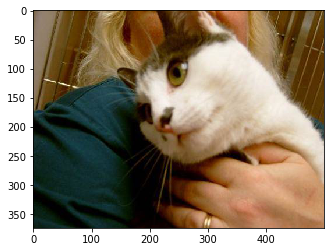

In [7]:
plt.imshow(img)

# 1. 并行计算

## 1.1. 顺序处理

In [8]:
%%time
for x in files:
    img = read(x)
    out = process(img)

CPU times: user 19.6 s, sys: 102 ms, total: 19.7 s
Wall time: 21.2 s


把它拆解成两个循环分别测试

In [9]:
%%time
for x in files:
    img = read(x)

CPU times: user 3.59 s, sys: 23.6 ms, total: 3.61 s
Wall time: 3.91 s


In [10]:
imgs = [read(x) for x in files]

In [11]:
%%time
for x in imgs:
    out = process(x)

CPU times: user 15.5 s, sys: 67.7 ms, total: 15.6 s
Wall time: 16.7 s


## 1.2. 并行处理

In [12]:
def read_and_process(x):
    return process(read(x))

以单线程作为Baseline

In [13]:
%%time
outs = list(map(read_and_process, files))

CPU times: user 19.1 s, sys: 285 ms, total: 19.4 s
Wall time: 20.7 s


### 1.2.1. 并行全部过程

In [14]:
%%time
with mp.Pool(4) as p:
    outs = p.map(read_and_process, files)

CPU times: user 286 ms, sys: 730 ms, total: 1.02 s
Wall time: 7.22 s


In [15]:
%%time
with mp.Pool(32) as p:
    outs = p.map(read_and_process, files)

CPU times: user 295 ms, sys: 2 s, total: 2.3 s
Wall time: 5.02 s


### 1.2.2. 并行+并行

In [16]:
%%time
with mp.Pool(8) as p:
    outs = p.map(read_and_process, files)

CPU times: user 336 ms, sys: 1.1 s, total: 1.44 s
Wall time: 5.38 s


在同一组线程内：

In [17]:
%%time
with mp.Pool(8) as p:
    imgs = p.map(read, files)
    outs = p.map(process, imgs)

CPU times: user 1.14 s, sys: 1.95 s, total: 3.09 s
Wall time: 6.85 s


在不同组线程内：

In [18]:
%%time
with mp.Pool(8) as p:
    imgs = p.map(read, files)
    
with mp.Pool(8) as p:
    outs = p.map(process, imgs)

CPU times: user 1.18 s, sys: 3.08 s, total: 4.26 s
Wall time: 9.06 s


### 1.2.2. 串行+并行

一个自然的想法是：

1. 串行读取数据
2. 并行处理数据

从而拿到更好的结果。而实际上这种操作在大多数时候是不可行的

In [19]:
%%time
imgs = [read(x) for x in files]

with mp.Pool(8) as p:
    outs = p.map(process, imgs)

CPU times: user 4.77 s, sys: 2.61 s, total: 7.39 s
Wall time: 9.89 s


**仅在该例中：**

并行全部过程 > 并行+并行 > 串行+并行 > 串行全部过程

## 1.3. IO密集型与计算密集型

* 如果函数涉及到大量的文件读写，则称为**IO密集型**
* 如果函数涉及到大量的计算，则称为**计算密集型**

### 1.3.1 关于磁盘读写

* 假如在一块读取速度有100M/s的机械硬盘上同时有10个程序在做读取操作，那么每个程序的读取速度可能会下降到5M/s
* 大量小文件的读取速度远低于单个大文件的读取速度 -- 随机读取速度远低于顺序读取
* 固态硬盘的读取速度远大于机械硬盘的读取速度，特别是随机读写速度
* 单通道硬盘如果同时作读写操作，例如在磁盘内进行复制黏贴，则速度会大大降低
* RAID（磁盘阵列）速度要大于单块硬盘的速度，并且支持多通道

换句话说：

* 尽量不要同时进行读写操作

In [20]:
%%time
with mp.Pool(2) as p:
    imgs = p.map(read, files)

CPU times: user 235 ms, sys: 1.05 s, total: 1.29 s
Wall time: 4.17 s


In [21]:
%%time
with mp.Pool(16) as p:
    imgs = p.map(read, files)

CPU times: user 429 ms, sys: 2.2 s, total: 2.63 s
Wall time: 4.75 s


* 如果可以，将数据集打包成存储（例如`.mat`或`.npy`)

In [22]:
np.save("dataset.npy", np.array(imgs))
%time imgs = np.load("dataset.npy") # ~2x speed up

CPU times: user 1.19 s, sys: 607 ms, total: 1.8 s
Wall time: 2.06 s


* 将数据集存储在机械硬盘下容易导致IO瓶颈

* 对象存储OSS需要极高的带宽资源才不至于成为性能瓶颈

### 1.3.2. 关于并行计算

关于计算密集型程序，在合适的条件下可以通过并行计算来进行加速：

并行执行时间 = 线程创建时间 + 数据传输时间 + 任务数/线程数 * 单个任务执行时间

大致的结论如下：

* 过细粒度的函数不适合并行操作 -- 线程创建时间占比过大
* 并行过程中要尽量减少线程间的数据传输 -- 大批的数据读取放在线程内执行可以避免数据传输
* 并行并不是越多越好 -- 并行越多，非计算所需的时间占比越大

![](parallel_speedup.png)

### 1.4. 小结

> 何快速读取这一批图片？

根据存储设备的实际情况来作决定，大部分时候以下决策总是有效的：

* 避免大量的小文件读写
* 避免多个程序/进程同时进行读写

> 如何快速对这一批图片进行处理？

尝试使用并行计算，但并非所有情况并行计算都能带来很好的性能提升

关于并行计算，可以参考[潘建瑜 2019秋 并行计算](http://math.ecnu.edu.cn/~jypan/Teaching/ParaComp/index.html)

> 假如`dataset`中有60G或者600G数据呢？

见下文 :D

## 2. 迭代器 Iterator

迭代器的核心思想在于：lazy loading/evaluation

迭代器解决了两个问题：

* 过早地生成了生成不必要的数据
* 超大数据集无法读取的问题

* 时间换空间
* 空间换时间
* lazy evalutation

In [23]:
def train(img):
    np.random.randn(128, 128)
    

In [32]:
%%time
# eager loading
imgs = [read(x) for x in files]

for epoch in range(2):
    for img in imgs:
        train(img)

CPU times: user 11.2 s, sys: 611 ms, total: 11.8 s
Wall time: 13.1 s


In [33]:
%%time
# lazy loading
for epoch in range(2):
    for x in files:
        img = read(x)
        out = process(img)

CPU times: user 1min 17s, sys: 1.18 s, total: 1min 19s
Wall time: 1min 25s


## 2.1. Lazy loading -- 只在需要地时候读取数据

场景一：

尽管600G的训练数据无法直接存储到内存中，但是我们可以在训练过程中分批次地读取数据

In [34]:
def train(img):
    np.random.randn(128, 128)

所有数据一口气读取进来:
    
* 训练数据只读取一次 -- 快
* 内存占用大 -- 对于超大数据集而言这几乎不可行

In [35]:
%%time
imgs = [read(x) for x in files]

for epoch in range(2):
    for x in imgs:
        train(x)

CPU times: user 11.6 s, sys: 274 ms, total: 11.9 s
Wall time: 12.8 s


只在需要的时候分批读取数据:
    
* 每个epoch都需要重新读取数据 -- 慢
* 内存占用小

这是一种**时间换空间**的策略

In [38]:
%%time
# 仅在需要的时候读取数据，处理完后数据立刻释放
for epoch in range(2): # lazy loading
    for x in files:
        img = read(x)
        out = train(img)

CPU times: user 19.3 s, sys: 382 ms, total: 19.6 s
Wall time: 20.3 s


这里我们存储了数据集中每个图片的路径，并且在需要的时候通过`read`来读取，能否将这一步简化呢？

实际上我们只需要实现`__getitem__`函数即可

In [39]:
class ImageDataset:
    def __init__(self, root):
        self.files = [os.path.join(root, x) for x in os.listdir(root)]
        
    def __getitem__(self, index):
        if isinstance(index, int):
            return mpimg.imread(self.files[index])
        else:
            return [mpimg.imread(x) for x in self.files[index]]
    
    def __len__(self):
        return len(self.files)

In [40]:
dataset = ImageDataset(root)

尽管ImageDataset中存储的是文件路径，但是它可以像一个列表一样使用，并且取下标时拿到的是图片而不是文件路径

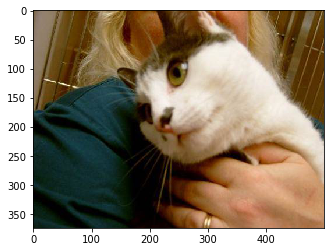

In [41]:
plt.imshow(dataset[0])

于是我们可以以如下方式读取训练数据：

In [42]:
%%time
imgs = [read(x) for x in files]

for epoch in range(2):
    for img in imgs:
        train(img)

CPU times: user 11.3 s, sys: 292 ms, total: 11.6 s
Wall time: 12.2 s


但是这里并没有改变代码结构：我们只不过从迭代文件路径改成了迭代下标

```python
for epoch in range(5):
    for x in files:
        img = read(x)
        out = train(img)
```

问：能否像一个列表一样进行迭代呢？例如

```python
imgs = ImageDataset(root)

for epoch in range(2):
    for img in imgs:
        train(img)
```

In [43]:
# 问：这样可以吗
imgs = ImageDataset(root)

for epoch in range(2):
    for img in imgs[0:2000]: # 实际上还是一口气把数据集全部读进来了
        train(img)

## 2.2. 迭代器

为了这个目的，我们引入 **迭代器(Iterator)** 的概念：

* 迭代器就是实现了`__iter__`和`__next__`的类
* 迭代器并不存储完整的数据 -- 不占用额外的内存空间
* 迭代器只是定义
  * 数据是如何构造出来的
  * [optional] 数据构造到何时结束

In [44]:
class my_range:
    def __init__(self, n):
        self.i = 0
        self.end = n

    def __iter__(self):
        return self
    
    def __next__(self):
        if self.i < self.end:
            i = self.i
            self.i += 1
            return i
        else:
            raise StopIteration()

In [45]:
for i in my_range(5):
    print(i)

0
1
2
3
4


回到例子中：

In [46]:
class Dataloader:
    def __init__(self, dataset, end=None):
        self.end = len(dataset) if end is None else end
        self.dataset = dataset
    
    def __iter__(self):
        return Dataloader._DataIterator(self.dataset, end=self.end)
    
    
    class _DataIterator:
        def __init__(self, dataset, end):
            self.i = 0
            self.end = end
            
        def __next__(self):
            if self.i < self.end:
                img = dataset[self.i]
                self.i += 1
                return img
            else:
                raise StopIteration()

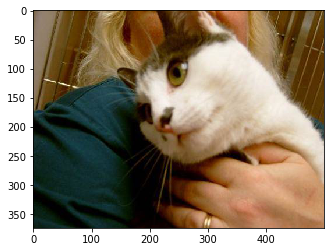

In [47]:
root = "dataset"
train_dataloader = Dataloader(ImageDataset(root))

plt.imshow(next(iter(train_dataloader)))

对比迭代器方法和普通方法的实际开销：

In [48]:
%time imgs = Dataloader(ImageDataset(root), end=2000) # 几乎没有开销
img_iter = iter(imgs)
%time img = next(img_iter) # 每一次图片读取的开销被花在此处

CPU times: user 79.1 ms, sys: 16.2 ms, total: 95.3 ms
Wall time: 94.8 ms
CPU times: user 6.6 ms, sys: 0 ns, total: 6.6 ms
Wall time: 6.54 ms


In [49]:
%time imgs = [read(x) for x in files] # 所有图片读取的开销在此处
%time img = imgs[0] # 几乎没有开销

CPU times: user 7.39 s, sys: 298 ms, total: 7.68 s
Wall time: 8.1 s
CPU times: user 10 µs, sys: 0 ns, total: 10 µs
Wall time: 13.4 µs


In [50]:
%%time

# 一：提前将数据集读取进内存
root = "dataset"
files = [os.path.join(root, x) for x in os.listdir(root)]
files = files[0:2000]

imgs = [read(x) for x in files]

for epoch in range(2):
    for img in imgs:
        train(img)

CPU times: user 11.6 s, sys: 484 ms, total: 12.1 s
Wall time: 12.7 s


In [51]:
%%time

# 二：在迭代过程中反复读取数据集
root = "dataset"
files = [os.path.join(root, x) for x in os.listdir(root)]
files = files[0:2000]

for epoch in range(2):
    for x in files:
        img = read(x)
        train(img)

CPU times: user 19.4 s, sys: 379 ms, total: 19.7 s
Wall time: 20.6 s


In [52]:
%%time

# 三：利用迭代器来读取数据集
root = "dataset"
imgs = Dataloader(ImageDataset(root))
imgs = [read(x) for x in files]

for epoch in range(2):
    for img in imgs:
        train(img)

CPU times: user 11.2 s, sys: 328 ms, total: 11.5 s
Wall time: 12.3 s


## 2.3. 小结

迭代器的核心作用：

* 构造一个类似于列表的类用于for循环
* lazy loading/evaluation 从而减少内存开销
* 这是一个**空间换时间**的技术 -- 但并不总是慢的

对于较小的数据集：没有必要使用迭代器，直接将整个数据集塞进内存即可